# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

#### Gathering Data 

In [270]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm

# % matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Assess Data

In [2]:
print(portfolio.head())
print(portfolio.shape)

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
(10, 6)


In [3]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [4]:
print(profile.head())
print(profile.shape)

   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN
(17000, 5)


In [5]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [6]:
profile.isna().sum(axis=0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [9]:
print(transcript.shape)

(306534, 4)


In [10]:
transcript.isna().sum(axis=0)

event     0
person    0
time      0
value     0
dtype: int64

In [11]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

### Data Preparation/ Exploration

#### Data Cleaning

In [12]:
# Convert int to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [13]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
profile.dtypes

age                          int64
became_member_on    datetime64[ns]
gender                      object
id                          object
income                     float64
dtype: object

In [15]:
# Remove Outliers that potentially have incorrect ages
Q1 = profile.age.quantile(0.25)
Q3 = profile.age.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
profile_1 = profile.loc[(profile['age']  > Q1 - 1.5 * IQR) & (profile['age']  < Q3 + 1.5 * IQR)]


28.0


In [16]:
# One hot encoding

def one_hot_encoding(df, cl):
    for column in cl:
        column_dummies = pd.get_dummies(df[column])
        df = df.drop(column, axis = 1)
        df = df.join(column_dummies)
    return df

In [17]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [18]:
# One hot encode
columns = ['offer_type']
portfolio_encode = one_hot_encoding(portfolio, columns)
portfolio_encode.head()

,channels,difficulty,duration,id,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


In [19]:
portfolio_encode['web'] = portfolio_encode['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio_encode['email'] = portfolio_encode['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio_encode['mobile'] = portfolio_encode['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio_encode['social'] = portfolio_encode['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [20]:
portfolio_encode = portfolio_encode.drop('channels', axis = 1)


In [21]:
portfolio_encode.describe()

,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,7.700000,6.500000,4.200000,0.400000,0.400000,0.200000,0.800000,1.0,0.900000,0.600000
std,5.831905,2.321398,3.583915,0.516398,0.516398,0.421637,0.421637,0.0,0.316228,0.516398
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000
50%,8.500000,7.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000
75%,10.000000,7.000000,5.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.000000,1.000000
max,20.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


In [22]:
# Characteristics about the data - email is all one so does not have any predictive attributes
portfolio_encode = portfolio_encode.drop('email', axis = 1)


In [23]:
portfolio_encode.head()

,difficulty,duration,id,reward,bogo,discount,informational,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0


In [24]:
# One hot encode transcript
columns_transcript = ['event']
transcript_encode = one_hot_encoding(transcript, columns_transcript)
transcript_encode.head()

,person,time,value,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [25]:
def display_keys(x):
    if x.keys() not in all_keys:
        all_keys.append(x.keys())

all_keys = []
transcript_encode['value'].apply(lambda x: display_keys(x))
print(all_keys)

[dict_keys(['offer id']), dict_keys(['amount']), dict_keys(['offer_id', 'reward'])]


In [26]:
def check_key(x, column, column1):
#       '''
#     data cleaning for transcript dataframe. Splits the values  based on parameters
    
#     INPUT:
#     columns to strip for new column
    
#     OUTPUT:
#     new column containing expanded data
    
#     '''
    if column in x.keys():
        return x[column]
    if column1 in x.keys():
        return x[column1]

In [27]:
# Split offers into new column
offer_id = transcript_encode['value'].apply(lambda x: check_key(x, 'offer_id','offer id'))
transcript_encode['offer_id'] = offer_id

In [28]:
# split amount into new column
amount = transcript_encode['value'].apply(lambda x: check_key(x, 'amount','amount'))
transcript_encode['amount'] = amount

In [29]:
# split reward into new column
reward = transcript_encode['value'].apply(lambda x: check_key(x, 'reward','reward'))
transcript_encode['reward'] = reward

In [30]:
transcript_encode = transcript_encode.drop('value', axis = 1)

# Fill all of the NaN items with 0
transcript_encode.reward.fillna(0 , inplace=True)
transcript_encode.amount.fillna(0 , inplace=True)

In [31]:
# Remove all of the N/A offers
transcript_encode = transcript_encode[transcript_encode['offer_id'].notna()]

In [32]:
transcript_encode.head()

,person,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [33]:
transcript_encode = transcript_encode.rename(columns={"reward": "reward_received"})

In [34]:
# Find duration from start to finish

In [35]:
transcript_encode_temp = transcript_encode.loc[transcript_encode['offer completed'] == 1].filter(['person','offer_id','time'])

In [36]:
transcript_encode = transcript_encode.merge(transcript_encode_temp,how='left',on=['offer_id','person'])

In [37]:
transcript_encode = transcript_encode.rename(columns={"time_x": "time"})

In [38]:
transcript_encode['duration_to_complete'] = (transcript_encode['time_y'] - transcript_encode['time'])/24

In [39]:
transcript_encode = transcript_encode.drop('time_y', axis = 1)

In [46]:
# Merge Portfolio with Transcript
transcript_portfolio=transcript_encode.merge(portfolio_encode,how='left',left_on='offer_id',right_on ='id')


In [47]:
transcript_portfolio = transcript_portfolio.drop_duplicates(subset=None, keep="first", inplace=False)

In [50]:
transcript_portfolio1.head()

,person,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_received,duration_to_complete,difficulty,duration,id,reward,bogo,discount,informational,web,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5.5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,NaN,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,NaN,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,NaN,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,NaN,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1


In [48]:
transcript_portfolio1 = transcript_portfolio.loc[((transcript_portfolio.duration_to_complete < transcript_portfolio.duration) & (transcript_portfolio.duration_to_complete >= 0))| transcript_portfolio.duration_to_complete.isnull() == True]

In [ ]:
transcript_portfolio1_temp = transcript_portfolio1.filter(['time','offer viewed','person','offer_id'])

In [51]:
transcript_portfolio1.loc[(transcript_portfolio1.offer_id == '0b1e1539f2cc45b7b9fa7c272da2e1d7') & (transcript_portfolio1.person== 'd53717f5400c4e84affdaeda9dd926b3')]

,person,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_received,duration_to_complete,difficulty,duration,id,reward,bogo,discount,informational,web,mobile,social
15,d53717f5400c4e84affdaeda9dd926b3,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,1.25,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0
23944,d53717f5400c4e84affdaeda9dd926b3,30,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0.00,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0
23946,d53717f5400c4e84affdaeda9dd926b3,30,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,0.00,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0
159924,d53717f5400c4e84affdaeda9dd926b3,576,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,2.00,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0
189903,d53717f5400c4e84affdaeda9dd926b3,624,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,0.00,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0


In [67]:
transcript_portfolio1_temp = transcript_portfolio1.filter(['time','person','offer_id']).loc[transcript_portfolio1['offer viewed'] == 1]

In [73]:
transcript_portfolio2 = transcript_portfolio1.merge(transcript_portfolio1_temp,how='left',on=['offer_id','person'])

In [74]:
transcript_portfolio2['Viewed_Duration'] = (transcript_portfolio2['time_y'] - transcript_portfolio2['time_x'])/24

In [ ]:
transcript_portfolio2

In [77]:
transcript_portfolio2 = transcript_portfolio2.loc[((transcript_portfolio2.Viewed_Duration < transcript_portfolio2.duration))| transcript_portfolio2.Viewed_Duration.isnull() == True]

In [76]:
transcript_portfolio2 = transcript_portfolio2.drop_duplicates(subset=None, keep="first", inplace=False)

In [97]:
transcript_portfolio2.to_csv('temp.csv')

In [95]:
transcript_portfolio2.loc[(transcript_portfolio2.offer_id == 'a03223e636434f42ac4c3df47e8bac43') & (transcript_portfolio2.person== 'd53717f5400c4e84affdaeda9dd926b3')]

,person,time_x,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_received,duration_to_complete,...,id,reward,bogo,discount,informational,web,mobile,social,time_y,Viewed_Duration



Finding people who are converting based on completing offer recevied

1. People who are influenced and successfully convert - completed offer:

 -`offer received` -> `offer viewed`  -> `offer completed` 

2. People who received but did not complete offer - incomplete offer:

 -`offer received` -> `offer viewed`
 
 -`offer received`
 
 offer needs to be completed within the offer timeframe

In [105]:
transcript_portfolio3 = transcript_portfolio2.loc[transcript_portfolio2['offer received'] == 1]

In [87]:
transcript_portfolio3.head()

,person,time_x,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_received,duration_to_complete,...,id,reward,bogo,discount,informational,web,mobile,social,time_y,Viewed_Duration
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5.5,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,6.0,0.25
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,NaN,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,6.0,0.25
3,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,NaN,...,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,0,18.0,0.75
4,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,NaN,...,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,12.0,0.50
6,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,NaN,...,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,84.0,3.50


In [106]:
# If the duration to complete is N/A then it was not completed..
# if viewed_duration is negative then this was not viewed during this transaction

transcript_portfolio3['offer viewed'] = np.where(transcript_portfolio3['Viewed_Duration']< 0, 0,1)
transcript_portfolio3['offer completed'] = np.where(transcript_portfolio3['duration_to_complete'].isnull() == True, 0,1)
transcript_portfolio3['reward_received'] = np.where(transcript_portfolio3['offer completed'] == 1, transcript_portfolio3['reward'] ,0)

C:\Users\jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [107]:
transcript_portfolio3 = transcript_portfolio3.drop(['time_y','time_x','id'], axis = 1)

In [108]:
transcript_portfolio3.head()

,person,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_received,duration_to_complete,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,Viewed_Duration
0,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5.5,5,7,5,1,0,0,1,1,0,0.25
1,a03223e636434f42ac4c3df47e8bac43,0,1,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,NaN,20,10,5,0,1,0,1,0,0,0.25
3,e2127556f4f64592b11af22de27a7932,0,1,1,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,NaN,10,7,2,0,1,0,1,1,0,0.75
4,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,1,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,NaN,10,10,2,0,1,0,1,1,1,0.50
6,68617ca6246f4fbc85e91a2a49552598,0,1,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,NaN,10,5,10,1,0,0,1,1,1,3.50


#### Encode Profile 

In [111]:

# One hot encode
columns_profile = ['gender']
profile_encode = one_hot_encoding(profile, columns_profile)
# Drop N/A
profile_encode.dropna(inplace=True)

profile_encode.head()

,age,became_member_on,id,income,F,M,O
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


### Data Analysis 

#### Vizualizations 

In [140]:
import seaborn as sns

In [141]:
def age_group(row):
    if row["age"] < 13:
        return "age 12 years old"
    elif row["age"] < 18:
        return "12-17"
    elif row["age"] < 25:
        return "18-24"
    elif row["age"] < 35:
        return "25-34"
    elif row["age"] < 45:
        return "35-44"
    elif row["age"] < 55:
        return "45-54"
    elif row["age"] < 65:
        return "55-64"
    elif row["age"] < 75:
        return "65-74"
    else:
        return "75+"

In [142]:
def income_group(row):
    if row["income"] < 20000:
        return "Less than 20,000"
    elif row["income"] < 35000:
        return "20,000 to 34,999"
    elif row["income"] < 50000:
        return "35,000 to 49,999"
    elif row["income"] < 75000:
        return "50,000 to 74,999"
    elif row["income"] < 100000:
        return "75,000 to 99,999"
    else:
        return "100K+"
    



In [143]:
profile_encode['Age_Group'] = profile_encode.apply(age_group, axis=1)


In [144]:
profile_encode['Income_Group'] = profile_encode.apply(income_group, axis=1)


In [158]:
profile_encode['Year'] = profile_encode.became_member_on.dt.year

##### What is the distribution of Ages and Income

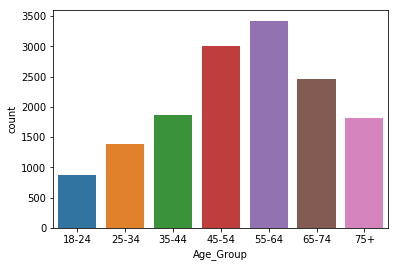

In [145]:
profile_encode1 = profile_encode.rename(columns={"id": "count"})
profile_encode_age = profile_encode1.groupby('Age_Group').count()
profile_encode_age.reset_index(inplace=True)
sns.barplot(x='Age_Group', y='count', data=profile_encode_age);

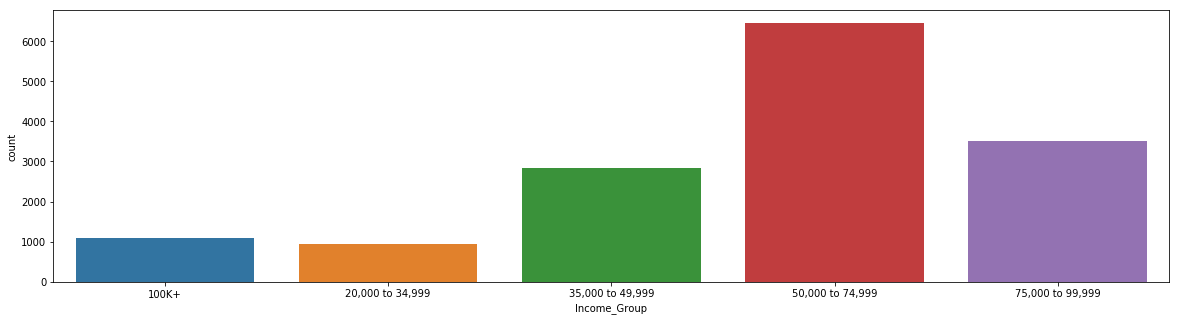

In [146]:


profile_encode1 = profile_encode.rename(columns={"id": "count"})
profile_encode_income = profile_encode1.groupby('Income_Group').count()
profile_encode_income.reset_index(inplace=True)
# plt.rcParams["axes.labelsize"] = 12
# plt.rc('xticks',fontsize=5) 
plt.figure(figsize=(20,5))
sns.barplot(x='Income_Group', y='count', data=profile_encode_income);


C:\Users\jlee\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 2160x360 with 0 Axes>

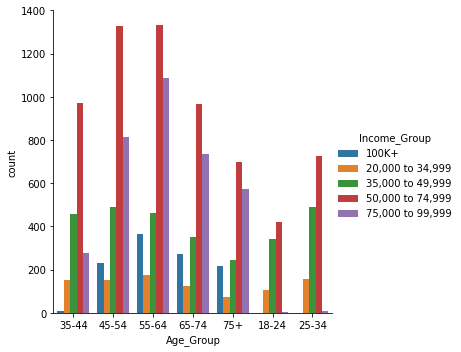

In [147]:
profile_encode_income_age = profile_encode1.groupby(['Income_Group','Age_Group'],as_index=False).count()
plt.figure(figsize=(30,5))

sns.factorplot(x='Age_Group', y='count', hue='Income_Group', data=profile_encode_income_age, kind='bar')


##### What is the distirbution of Gender 

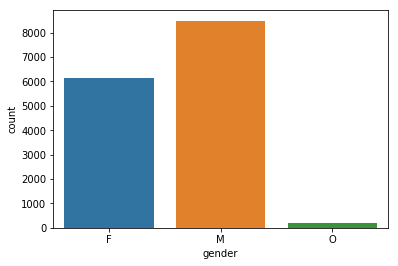

In [148]:
profile1 = profile.rename(columns={"id": "count"})

profile_encode_gender = profile1.groupby('gender').count()
profile_encode_gender.reset_index(inplace=True)
sns.barplot(x='gender', y='count', data=profile_encode_gender);

### Modeling Methodology 

In [149]:
profile_encode.head()

,age,became_member_on,id,income,F,M,O,Age_Group,Income_Group
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,55-64,100K+
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,75+,100K+
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,65-74,"50,000 to 74,999"
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,65-74,"50,000 to 74,999"
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,55-64,"50,000 to 74,999"


In [150]:
transcript_portfolio3.head()

,person,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_received,duration_to_complete,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,Viewed_Duration
0,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5.5,5,7,5,1,0,0,1,1,0,0.25
1,a03223e636434f42ac4c3df47e8bac43,0,1,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,NaN,20,10,5,0,1,0,1,0,0,0.25
3,e2127556f4f64592b11af22de27a7932,0,1,1,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,NaN,10,7,2,0,1,0,1,1,0,0.75
4,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,1,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,NaN,10,10,2,0,1,0,1,1,1,0.50
6,68617ca6246f4fbc85e91a2a49552598,0,1,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,NaN,10,5,10,1,0,0,1,1,1,3.50


In [190]:
final_model = transcript_portfolio3.merge(profile_encode,how='left',left_on='person',right_on='id')

In [191]:
final_model = final_model[final_model['age'].notna()]

In [194]:
final_model.head()

,offer completed,offer received,offer viewed,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,F,M,O,Age_Group,Income_Group,Year
0,1,1,1,5,7,5,1,0,0,1,1,0,1.0,0.0,0.0,75+,100K+,2017.0
2,0,1,1,10,7,2,0,1,0,1,1,0,0.0,1.0,0.0,65-74,"50,000 to 74,999",2018.0
5,1,1,1,5,5,5,1,0,0,1,1,1,0.0,1.0,0.0,65-74,"50,000 to 74,999",2018.0
7,0,1,1,0,4,0,0,0,1,1,1,0,0.0,1.0,0.0,55-64,"50,000 to 74,999",2017.0
8,0,1,1,20,10,5,0,1,0,1,0,0,1.0,0.0,0.0,55-64,"50,000 to 74,999",2017.0


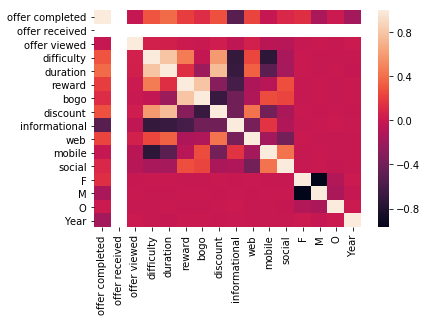

In [290]:
sns.heatmap(final_model.corr())


In [193]:
final_model = final_model.drop(['person','transaction','offer_id','amount', 'age','income','became_member_on','reward_received','Viewed_Duration','id','duration_to_complete'], axis = 1)

In [195]:
columns = ['Age_Group','Income_Group','Year']
final_model_encode = one_hot_encoding(final_model, columns)
final_model_encode.head(200)

,offer completed,offer received,offer viewed,difficulty,duration,reward,bogo,discount,informational,web,...,"20,000 to 34,999","35,000 to 49,999","50,000 to 74,999","75,000 to 99,999",2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
0,1,1,1,5,7,5,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,1,1,10,7,2,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
5,1,1,1,5,5,5,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
7,0,1,1,0,4,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,0
8,0,1,1,20,10,5,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0


In [236]:

#prepare model pipeline
def model_create(X_vars,y_var):
    '''
    inputs:
    - X_var 
    - y_var
    
    outputs: Training and Test Variable Dataframes
     -X_train, X_test, y_train and y_test 
    '''
    
    #split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_vars,y_var, 
                                                        test_size=0.20, 
                                                        random_state=30)

    return X_train,X_test,y_train, y_test

In [237]:
# prepare configuration for cross validation test harness
seed = 10
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [283]:
X_variable = final_model_encode.iloc[:, 1:]
y_variable = final_model_encode.iloc[:, 0]

In [289]:
X_variable

,offer received,offer viewed,difficulty,duration,reward,bogo,discount,informational,web,mobile,...,"20,000 to 34,999","35,000 to 49,999","50,000 to 74,999","75,000 to 99,999",2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
0,1,1,5,7,5,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
2,1,1,10,7,2,0,1,0,1,1,...,0,0,1,0,0,0,0,0,0,1
5,1,1,5,5,5,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
7,1,1,0,4,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
8,1,1,20,10,5,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
9,1,1,20,10,5,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
12,1,1,0,4,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
13,1,1,20,10,5,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
14,1,1,10,10,2,0,1,0,1,1,...,0,0,1,0,1,0,0,0,0,0
15,1,1,20,10,5,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1


Feature: 0, Score: -0.66121
Feature: 1, Score: -0.27604
Feature: 2, Score: -0.14034
Feature: 3, Score: 0.19899
Feature: 4, Score: 0.00616
Feature: 5, Score: 2.60967
Feature: 6, Score: 3.16267
Feature: 7, Score: -6.43355
Feature: 8, Score: 0.17945
Feature: 9, Score: -0.29446
Feature: 10, Score: 0.32638
Feature: 11, Score: -0.07808
Feature: 12, Score: -0.66418
Feature: 13, Score: 0.08104
Feature: 14, Score: -0.34876
Feature: 15, Score: -0.20125
Feature: 16, Score: -0.02552
Feature: 17, Score: -0.02441
Feature: 18, Score: -0.00923
Feature: 19, Score: -0.05340
Feature: 20, Score: 0.00135
Feature: 21, Score: 0.53359
Feature: 22, Score: -0.87415
Feature: 23, Score: -0.69630
Feature: 24, Score: -0.12816
Feature: 25, Score: 0.50380
Feature: 26, Score: -0.20540
Feature: 27, Score: -0.24341
Feature: 28, Score: 0.50375
Feature: 29, Score: 0.91860
Feature: 30, Score: -0.34607
Feature: 31, Score: -1.28868


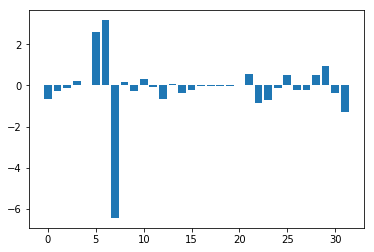

In [288]:
# Feature Importance 
model1 = LogisticRegression()
# fit the model
model1.fit(X_variable, y_variable)
# get importance
importance = model1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Create Model for all Offers

In [238]:
X_train, X_test, y_train, y_test=model_create(final_model_encode.iloc[:, 1:],final_model_encode.iloc[:, 0])

In [261]:
# evaluate each model in turn
results = []
names = []
score = 'accuracy'
for name, model in models:
    kf = model_selection.KFold(n_splits=10, random_state=seed)
    cross_val_results = model_selection.cross_val_score(model, X_train, y_train, cv=kf, scoring=score)
    results.append(cross_val_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cross_val_results.mean(), cross_val_results.std())
    print(msg)

LR: 0.782745 (0.005530)
LDA: 0.779926 (0.004532)
KNN: 0.761653 (0.005553)
CART: 0.779466 (0.005160)
NB: 0.720694 (0.005902)
SVM: 0.782479 (0.003761)


### Create Model for the BOGO Offers

In [253]:
final_model_encode_bogo = final_model_encode.loc[final_model_encode.bogo == 1]

In [254]:
final_model_encode_bogo = final_model_encode_bogo.drop(['bogo'], axis = 1)

In [255]:
X_train_bogo, X_test_bogo, y_train_bogo, y_test_bogo=model_create(final_model_encode_bogo.iloc[:, 1:],final_model_encode_bogo.iloc[:, 0])

In [256]:
results1 = []
names = []

for name, model in models:
    kf = model_selection.KFold(n_splits=10, random_state=seed)
    cross_val_results = model_selection.cross_val_score(model, X_train_bogo, y_train_bogo, cv=kf, scoring=score)
    results1.append(cross_val_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cross_val_results.mean(), cross_val_results.std())
    print(msg)

LR: 0.713321 (0.010857)
LDA: 0.714127 (0.010885)
KNN: 0.684452 (0.010863)
CART: 0.711083 (0.008108)
NB: 0.689419 (0.008293)
SVM: 0.711262 (0.008415)


### Create Model for the Discount Offers 

In [257]:
final_model_encode_discount = final_model_encode.loc[final_model_encode.discount == 1]

In [258]:
final_model_encode_discount = final_model_encode_discount.drop(['discount'], axis = 1)

In [259]:
X_train_discount, X_test_discount, y_train_discount, y_test_discount=model_create(final_model_encode_discount.iloc[:, 1:],final_model_encode_discount.iloc[:, 0])

In [260]:
results2 = []
names = []
for name, model in models:
    kf = model_selection.KFold(n_splits=10, random_state=seed)
    cross_val_results = model_selection.cross_val_score(model, X_train_discount, y_train_discount, cv=kf, scoring=score)
    results2.append(cross_val_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cross_val_results.mean(), cross_val_results.std())
    print(msg)

LR: 0.748954 (0.007393)
LDA: 0.748566 (0.007373)
KNN: 0.728379 (0.011600)
CART: 0.744123 (0.007875)
NB: 0.712117 (0.008106)
SVM: 0.748910 (0.005899)


We can see above that the all in one model scenario had the best fit based on the models run. Based on the 6 different models being run for each scenario logistic regression had the best overall mean accuracy scores based on a k_fold of 10 splits.

### Optimize LR for Model

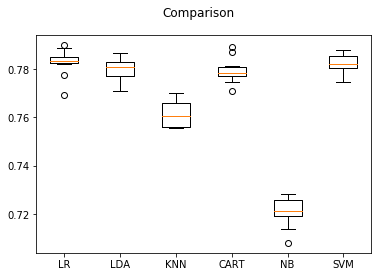

In [262]:
fig = plt.figure()
fig.suptitle('Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [265]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
        ('clf', LogisticRegression(random_state=seed))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
        ('pca', PCA(n_components=3)),
        ('clf', LogisticRegression(random_state=seed))])

In [277]:
# Set grid search params
param_range_fl = [1.0, 0.5, 0.1, .001, 10]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

In [273]:
# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10) 


In [274]:
# List of pipelines for ease of iteration
grids = [gs_lr]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.783
Test set accuracy score for best params: 0.784 

Classifier with best test set accuracy: Logistic Regression

Saved Logistic Regression grid search pipeline to file: best_gs.pkl


In [278]:
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7837090599744789
[[4806 2024]
 [1027 6249]]
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      6830
           1       0.76      0.86      0.80      7276

   micro avg       0.78      0.78      0.78     14106
   macro avg       0.79      0.78      0.78     14106
weighted avg       0.79      0.78      0.78     14106



AttributeError: 'GridSearchCV' object has no attribute 'estimator_'